# Evaluate agent

The following notebook can be used to train the RL agents and evaluate policies produced by the trained agents.

In [4]:
import sac_tri_envs_con, sac_tri, extra
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load the agent.

The following cell loads a pretrained RL agent and generates data useful for future plots.

In [40]:
#LOG_DIR = "data/E_tau=0.01"
LOG_DIR = "data/X_tau=5"

# Adaptive measurement is marked y the naming convention of the folders containing RL agents.
# In case of renaming the folders: assign the `adaptive_measurement` to a correct value 
# by modifying the rest of the cell.

# Check if LOG_DIR describes the adaptive measurement
if "R_tau" in LOG_DIR:
    adaptive_measurement = True
else:
    adaptive_measurement = False

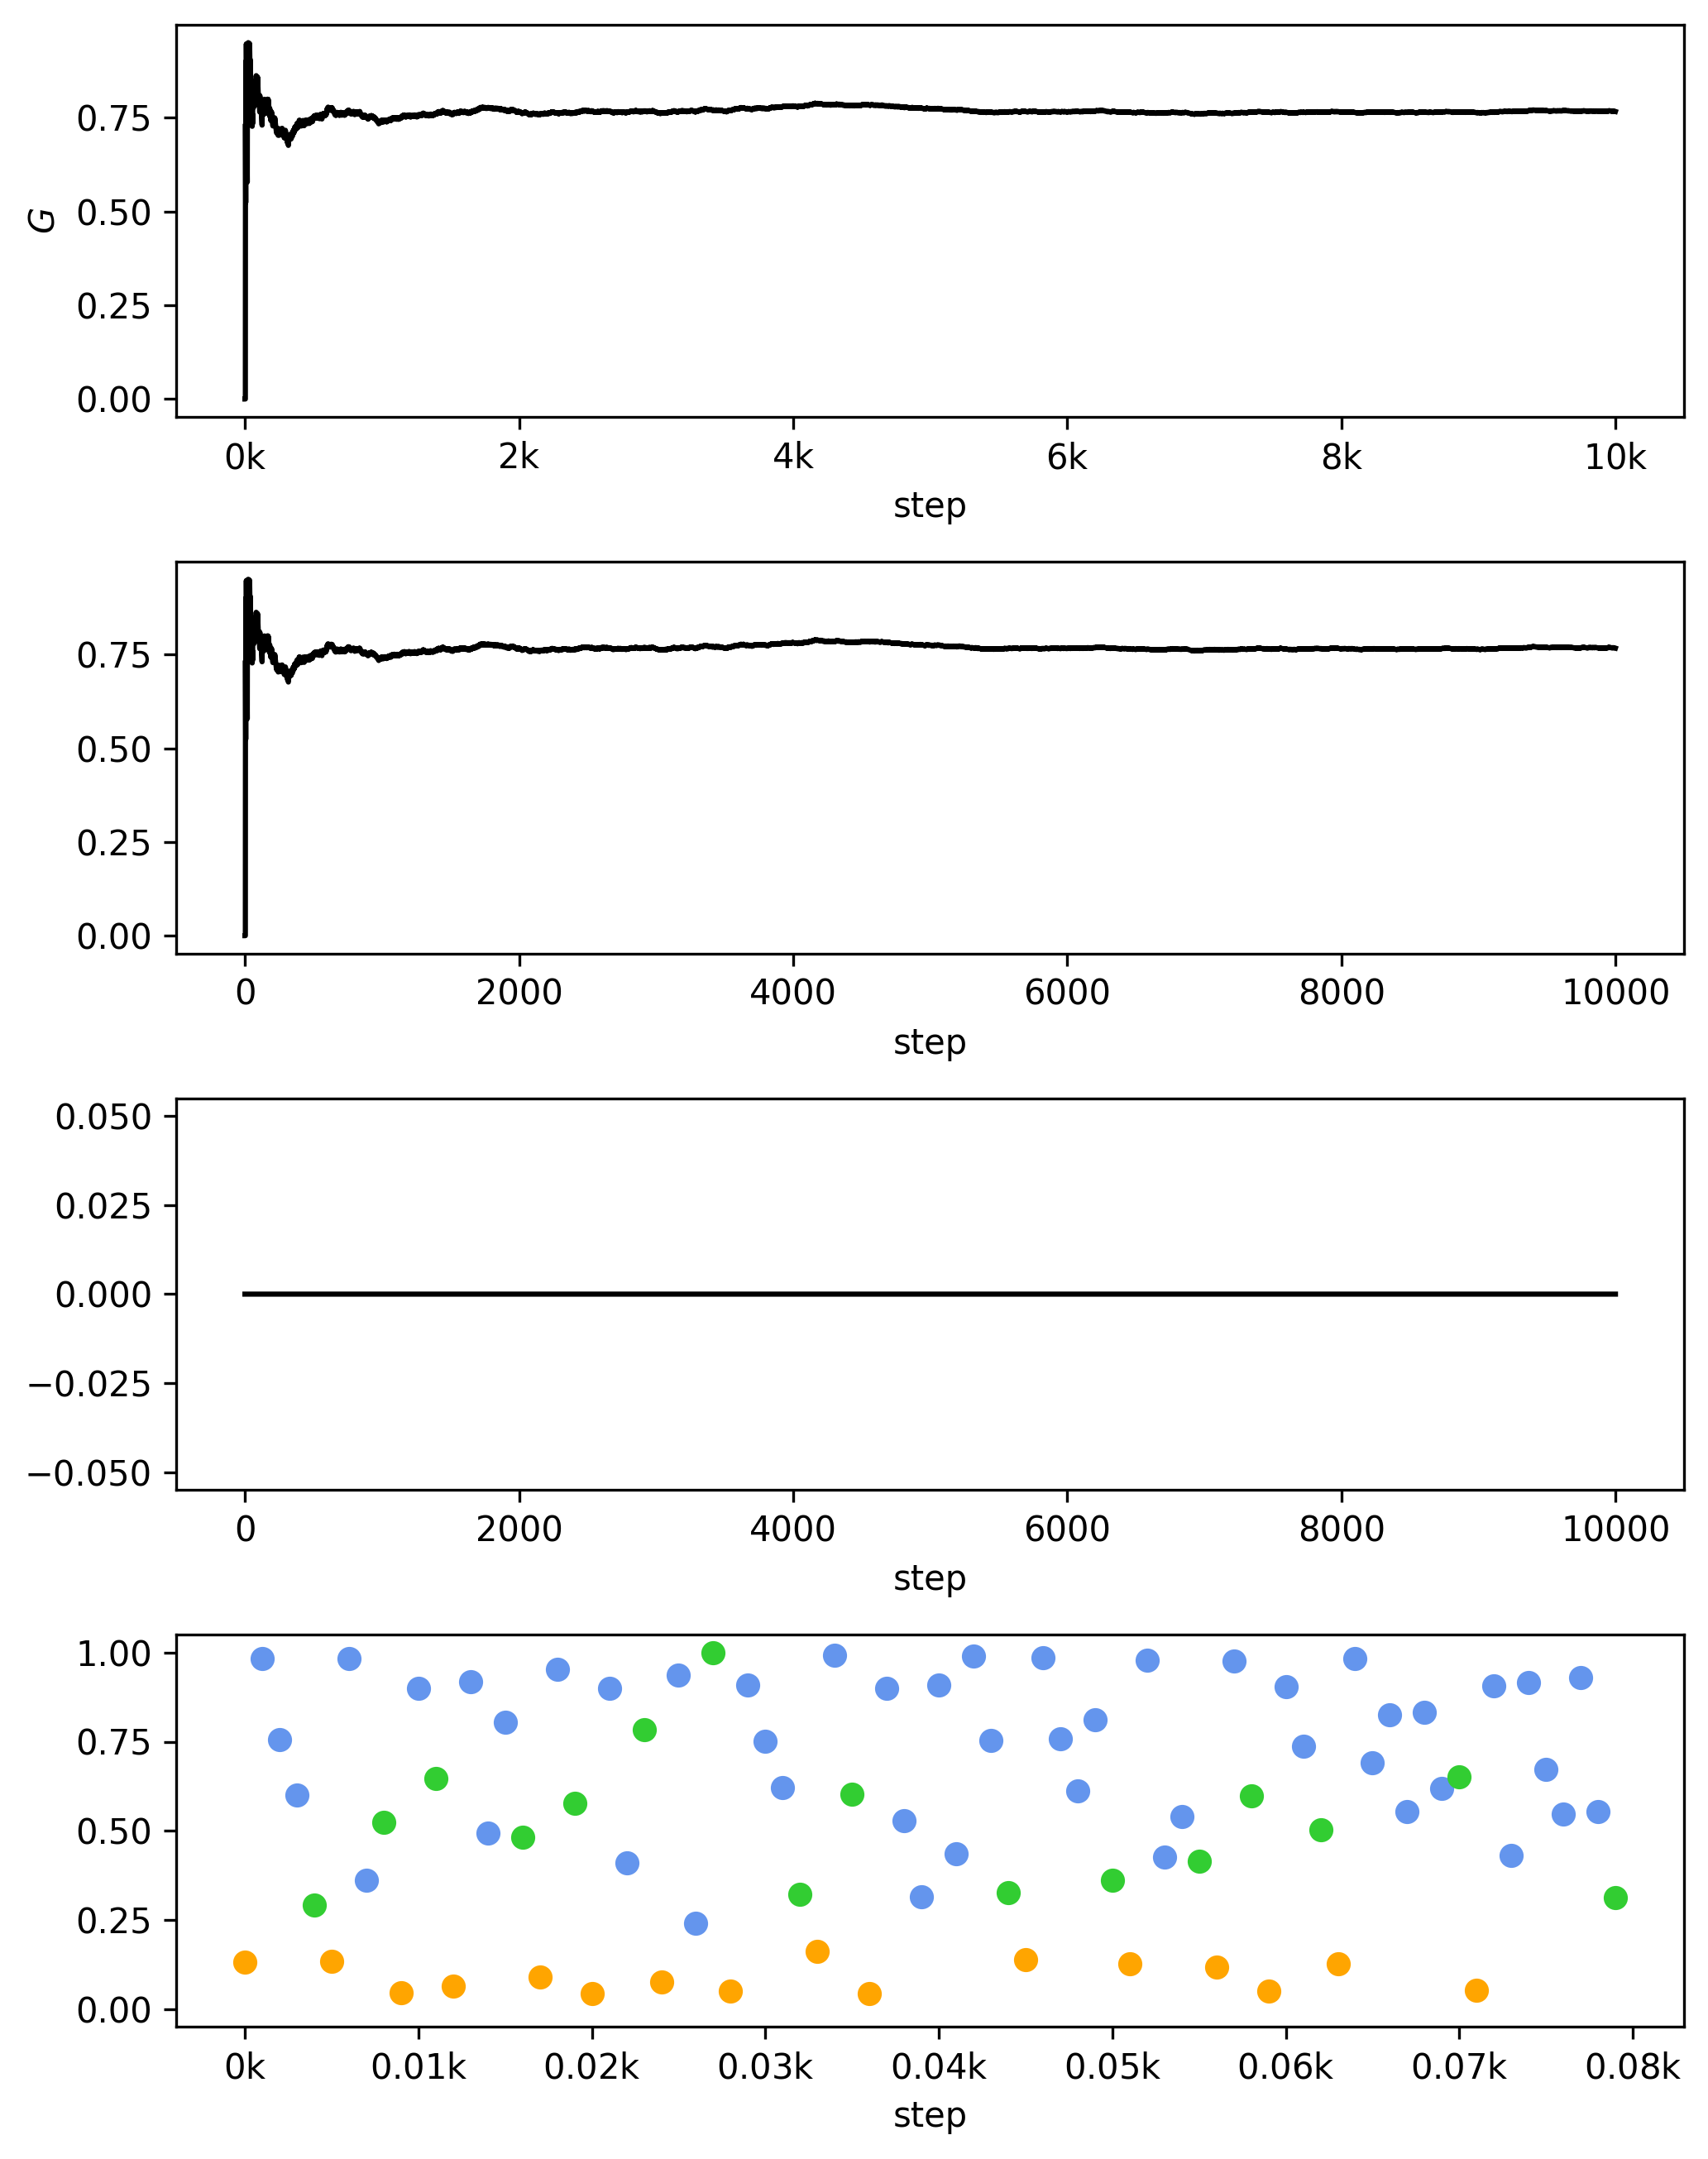

In [42]:


loaded_train = sac_tri.SacTrain()
loaded_train.load_train(LOG_DIR, no_train=True)
#evaluate the deterministic policy
_, _, info = loaded_train.evaluate_current_policy(deterministic=True, steps=10000, gamma=0.9999,actions_to_plot=80,
                                      save_policy_to_file_name="det_policy.txt",actions_ylim=[-0.05,1.05])

# Create a list of colors useful for plots later
colors = []
for idx, d_act in enumerate(info["discrete_actions"]):
    if d_act == 0:
        colors.append("orange")
    elif d_act == 1:
        if adaptive_measurement:
            theta = info["continuous_actions"][idx] * 3.6 - 0.2
            red_col = np.sin(theta)**2 
            blue_col = np.cos(theta)**2 
            colors.append( (red_col, 0.0, blue_col) )
        else:
            colors.append("cornflowerblue")
    elif d_act == 2:
        colors.append("limegreen")

if adaptive_measurement:
    #Plot legend with discrete elements
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Thermalization',
                          markerfacecolor='orange', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Feedback',
                          markerfacecolor='limegreen', markersize=10)]
else: 
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Thermalization',
                          markerfacecolor='orange', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Measurement',
                          markerfacecolor='cornflowerblue', markersize=10),
                       matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Feedback',
                          markerfacecolor='limegreen', markersize=10)] 

# 2. RL agent - single run visualization

In this section we perform a single run of the trained RL agent and plot resulting policy.

The following cell generates a plot in style of Fig. 5 in the paper.

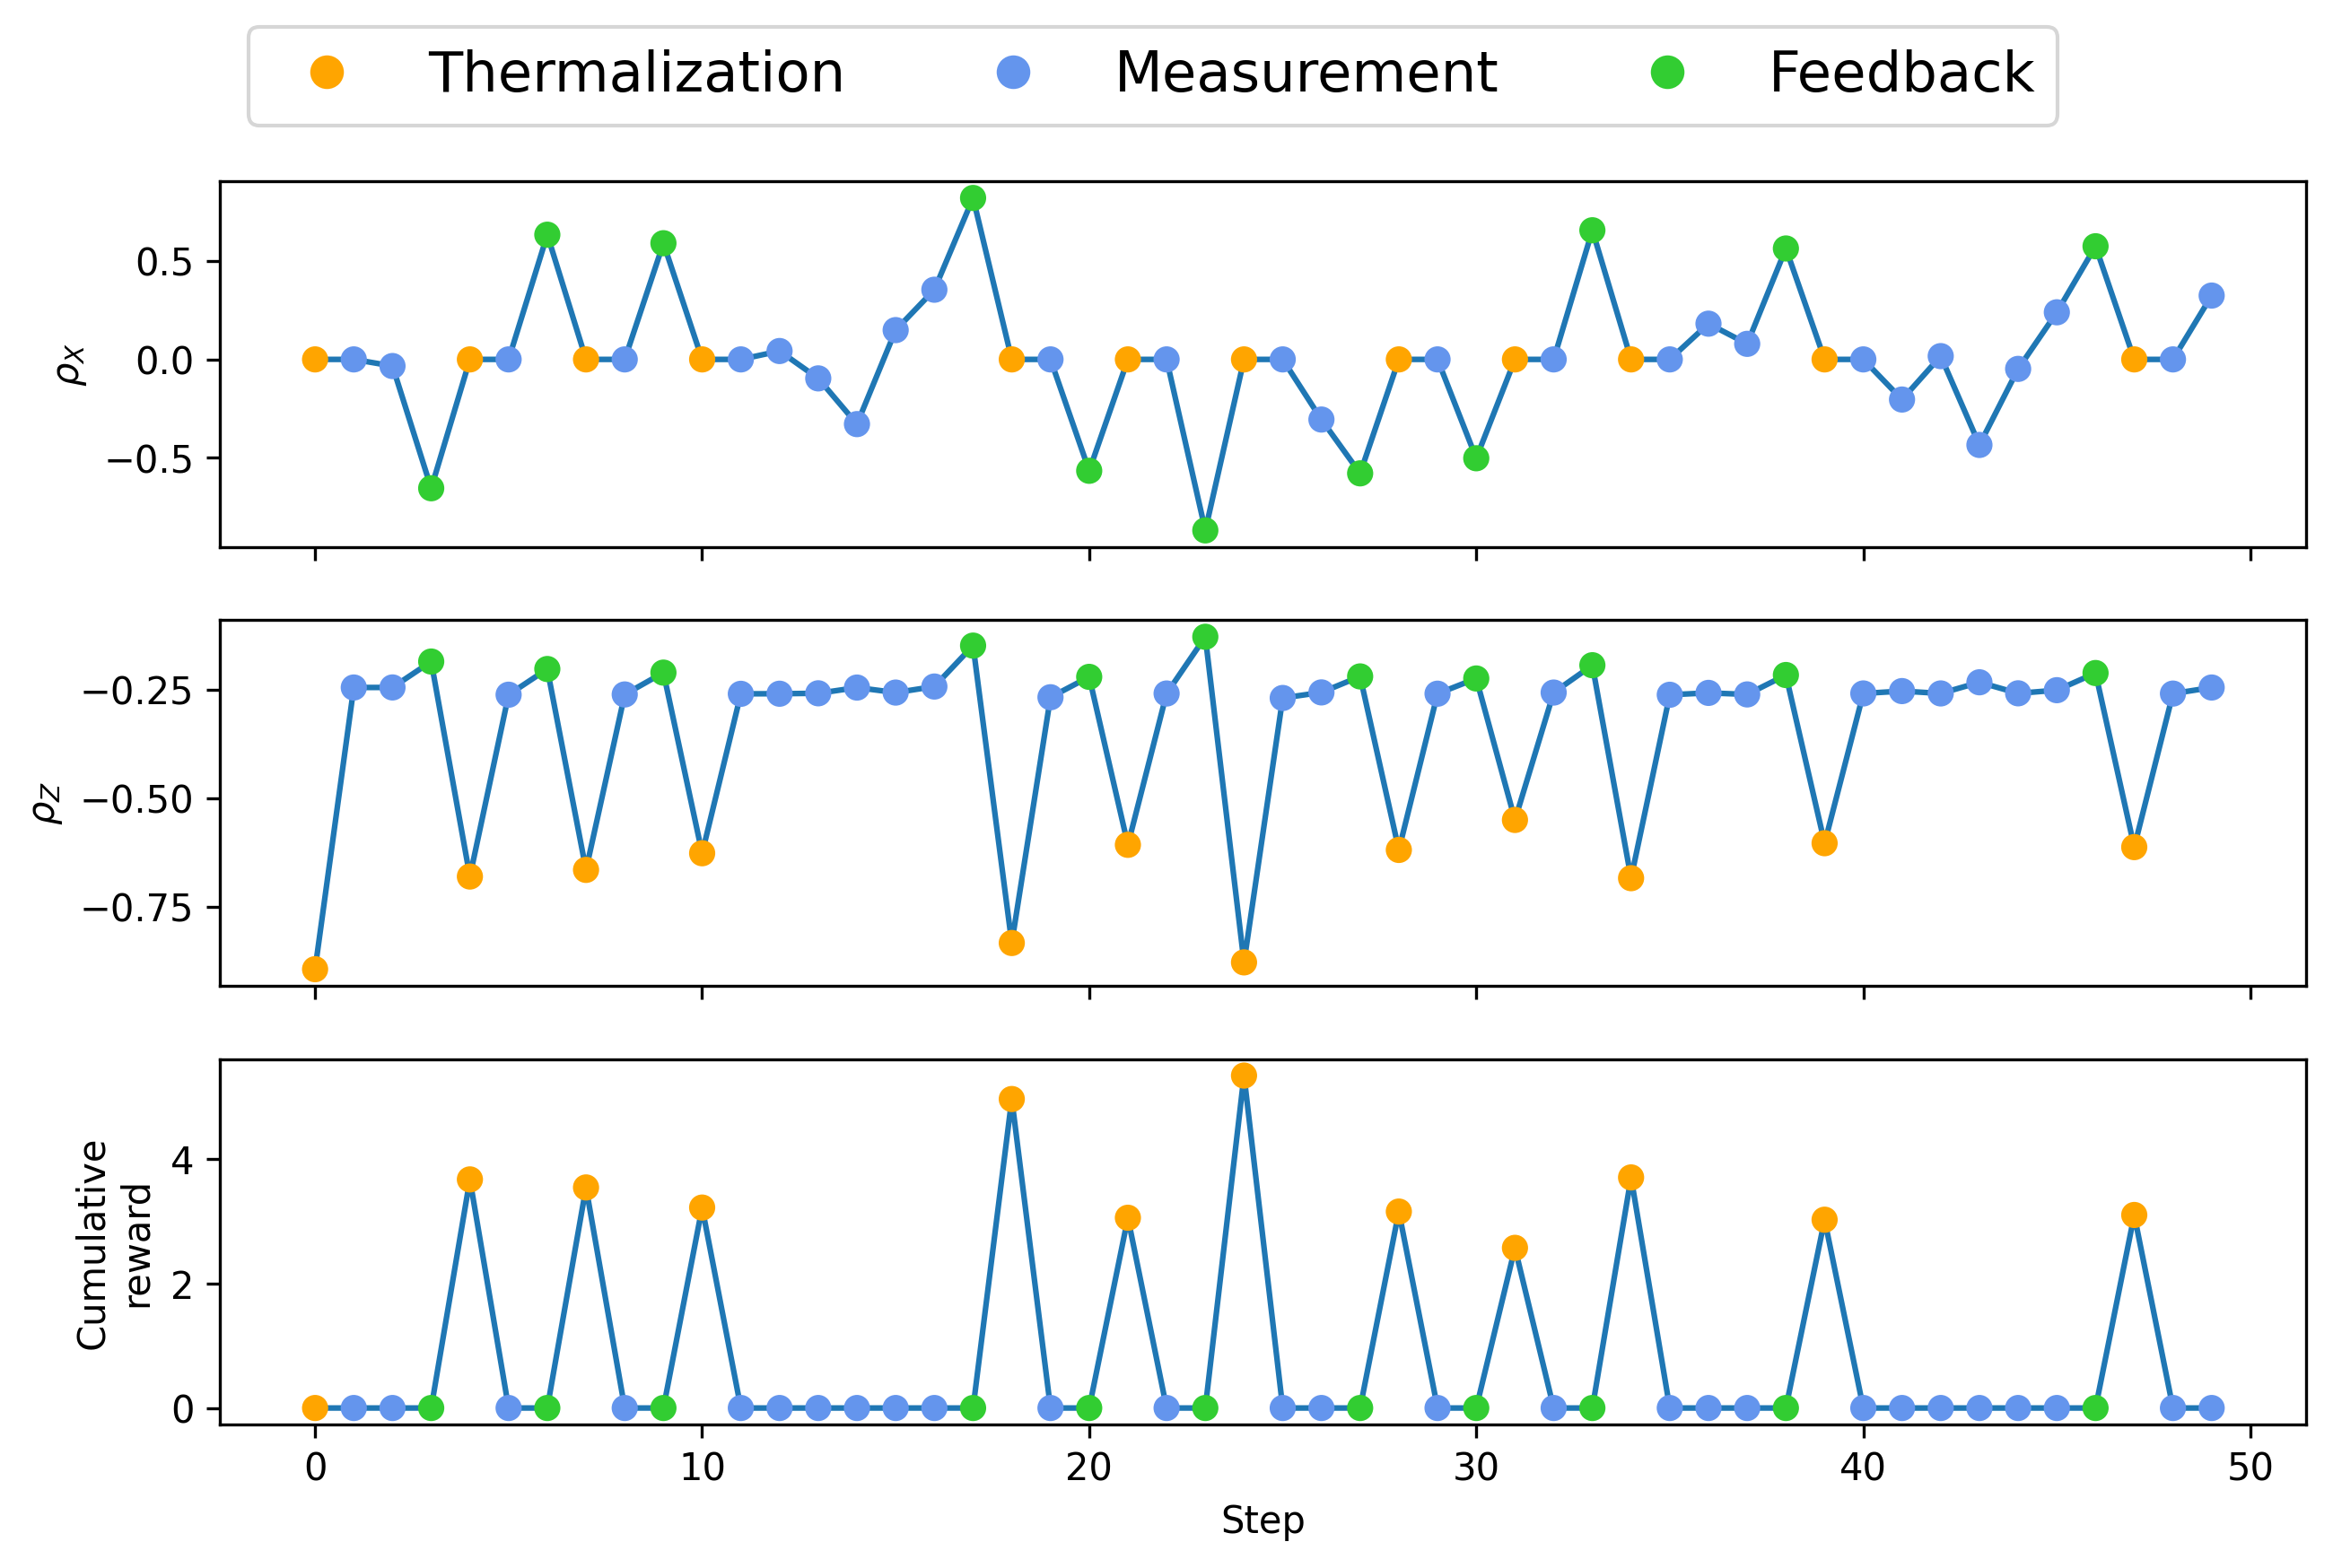

In [44]:
STEPS_TO_PLOT = 50

# Lists to store Bloch coordinates
X_s, Z_s = info["rhofx"], info["rhofz"]

if adaptive_measurement:
    image = matplotlib.image.imread("adaptive_measurement_colorbar.png")
    plt.imshow(image)
    plt.axis(False)

fig, axs = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (10,6))
axs[0].plot(range(STEPS_TO_PLOT), X_s[:STEPS_TO_PLOT], zorder = 0)
axs[0].scatter(range(STEPS_TO_PLOT), X_s[:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[0].set_ylabel(r"$\rho_X$")
axs[0].legend(handles=legend_elements, fontsize = 15, ncols = len(legend_elements),
                loc = "upper left", facecolor = "white", framealpha = 0.8,
                 bbox_to_anchor=(0.0, 1.50))

axs[1].plot(range(STEPS_TO_PLOT), Z_s[:STEPS_TO_PLOT], zorder = 0)
axs[1].scatter(range(STEPS_TO_PLOT), Z_s[:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[1].set_ylabel(r"$\rho_Z$")

axs[2].plot(range(STEPS_TO_PLOT), info["rewards"][:STEPS_TO_PLOT], zorder = 0)
axs[2].scatter(range(STEPS_TO_PLOT), info["rewards"][:STEPS_TO_PLOT], c = colors[:STEPS_TO_PLOT], zorder = 1)
axs[2].set_ylabel("Cumulative\nreward")
axs[2].set_xlabel("Step")

plt.show()

**Bloch plane plot**

The cell below generates the plots in style of Fig.4 in the paper. 

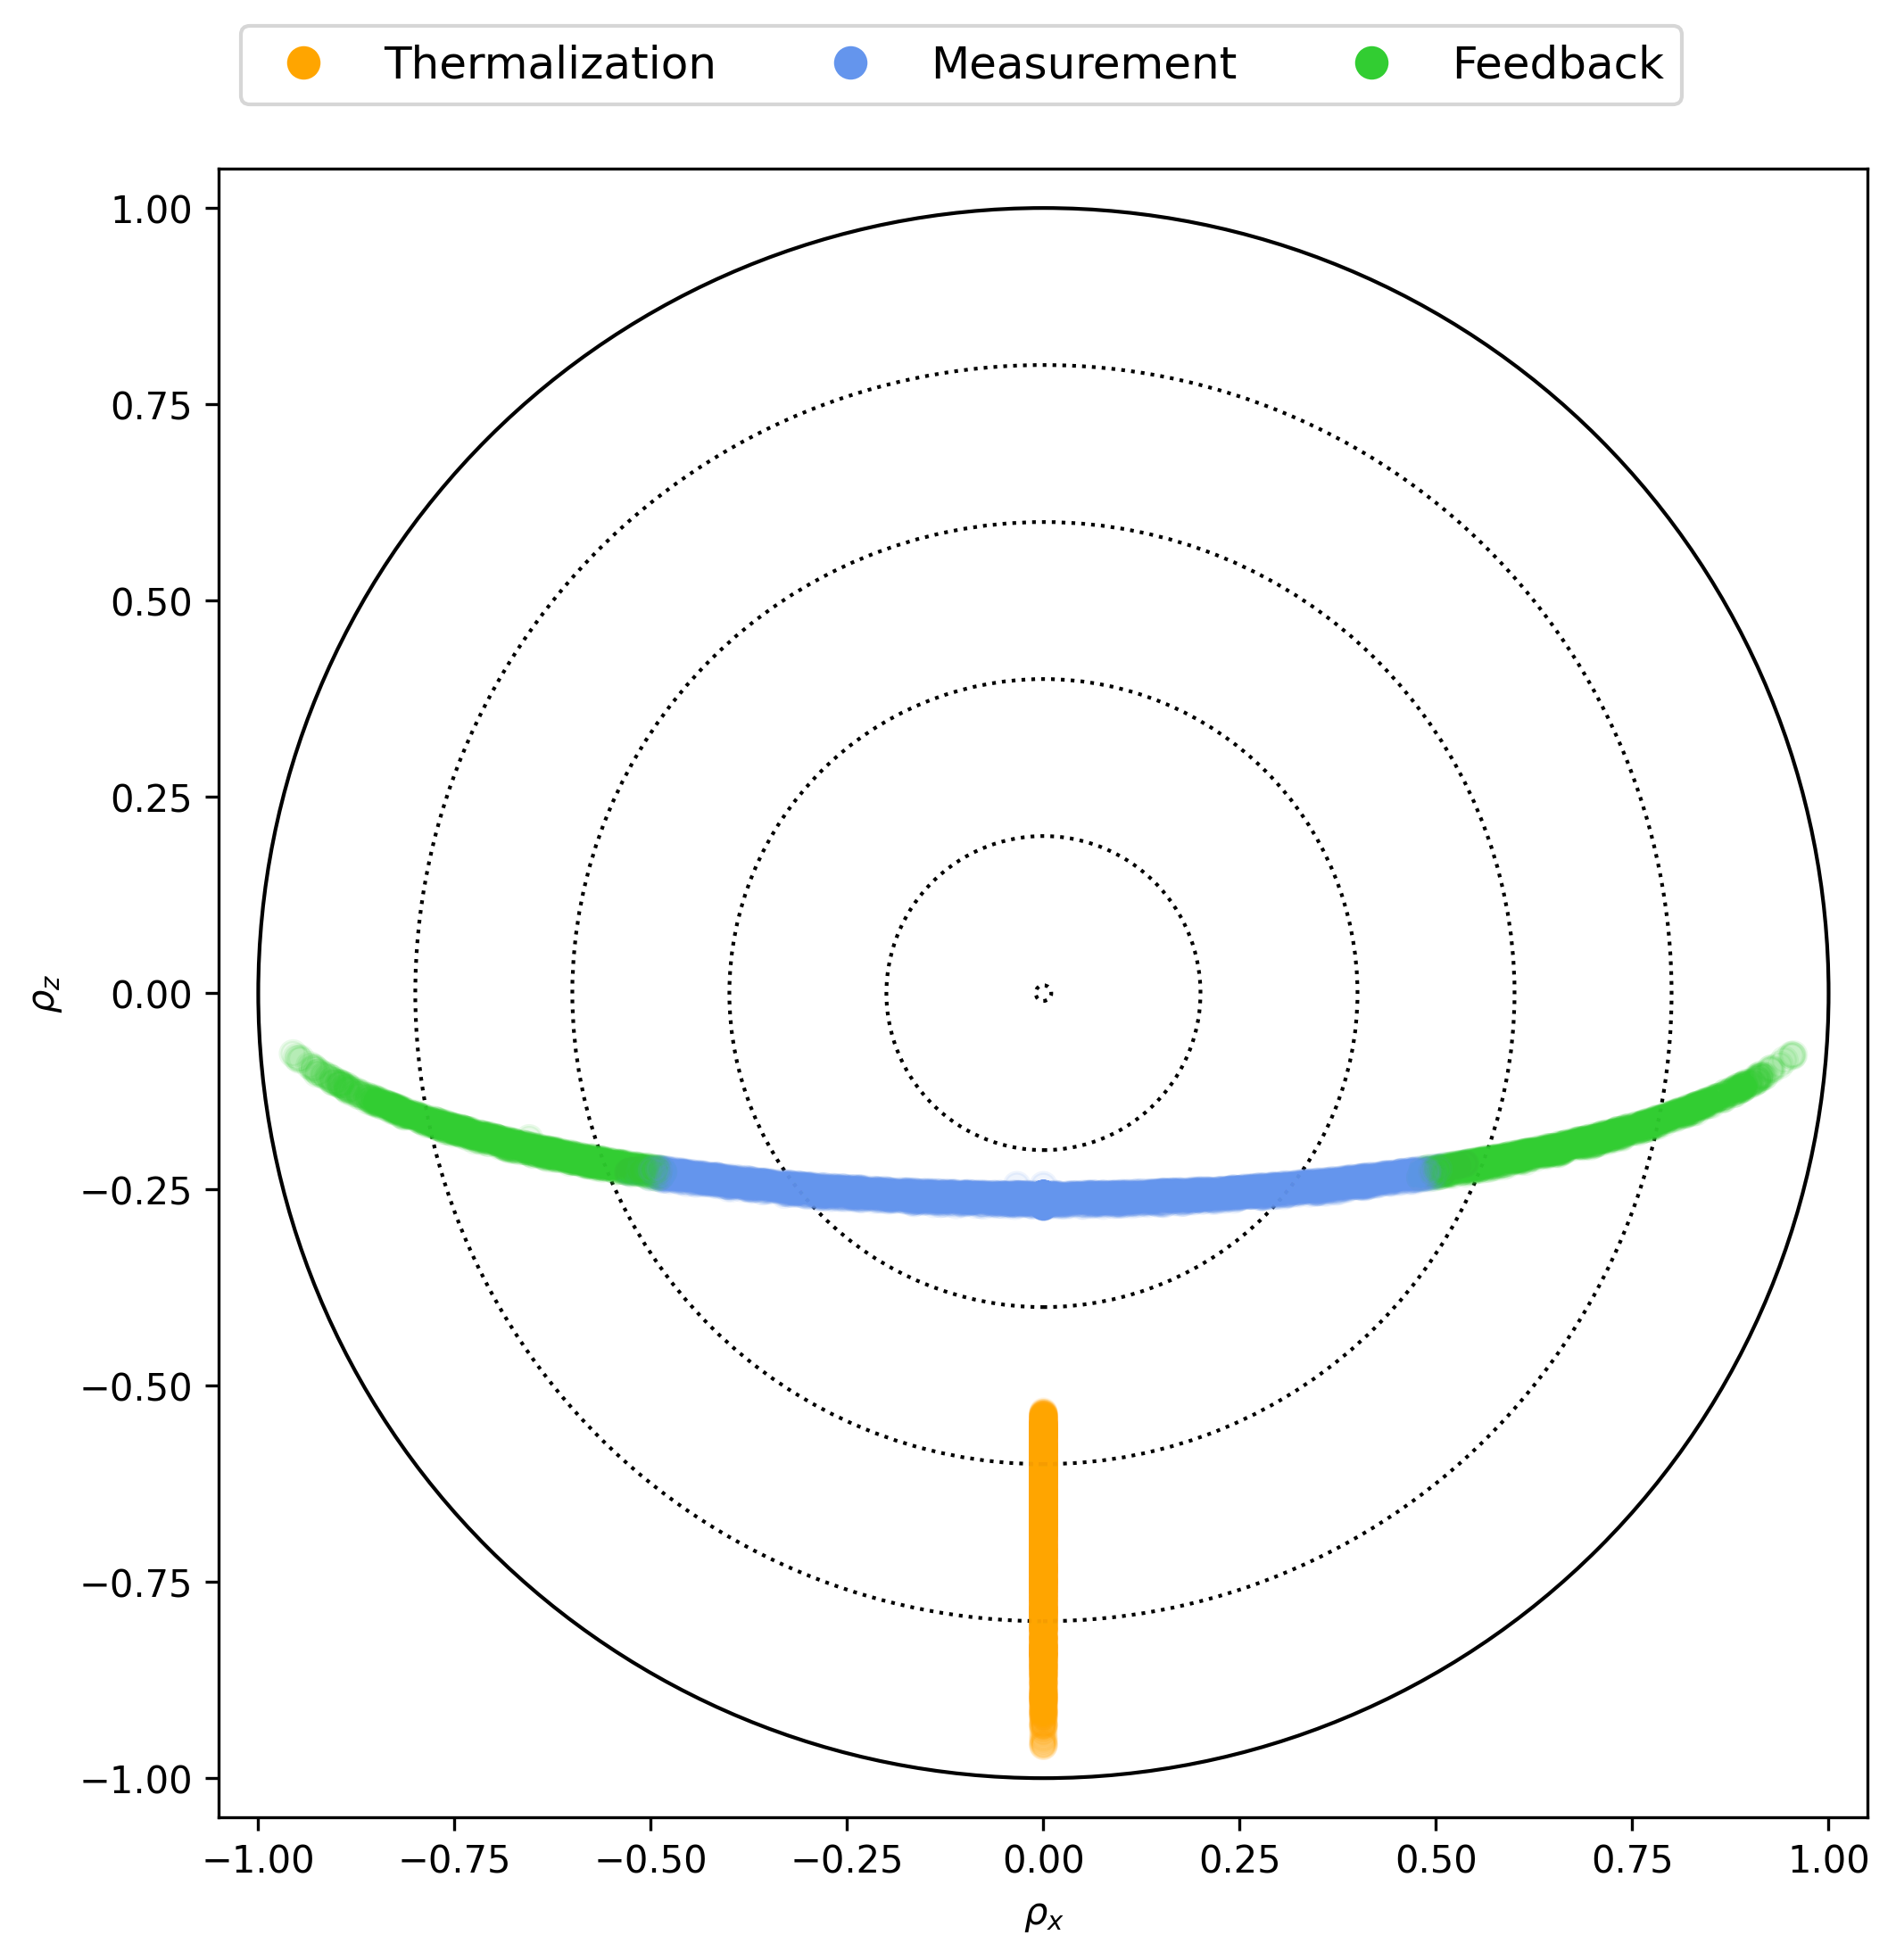

In [46]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

r1 = plt.Circle( (0.0, 0.0 ), 1.0 , fill = False )
r08 = plt.Circle( (0.0, 0.0 ), 0.8 , fill = False , linestyle = ":")
r06 = plt.Circle( (0.0, 0.0 ), 0.6 , fill = False , linestyle = ":")
r04 = plt.Circle( (0.0, 0.0 ), 0.4 , fill = False , linestyle = ":")
r02 = plt.Circle( (0.0, 0.0 ), 0.2 , fill = False , linestyle = ":")
r0  = plt.Circle( (0.0, 0.0 ), 0.01 , fill = False , linestyle = ":")
circle_list = [ r0, r02, r04, r06, r08, r1 ]
for r in circle_list:
    axs.add_artist( r )
# Plot properties
axs.set_aspect( 1 ) #Aspect ratio 
axs.set_xlim( -1.05, 1.05 )
axs.set_ylim( -1.05, 1.05 )
axs.set_xlabel(r"$\rho_x$")
axs.set_ylabel(r"$\rho_z$")
axs.legend(handles=legend_elements, fontsize = 12, ncols = len(legend_elements),
                loc = "upper left", facecolor = "white", framealpha = 0.8,
                 bbox_to_anchor=(0.0, 1.1))

axs.scatter(X_s[:-1], Z_s[:-1], c = colors[:], alpha = 0.10, s = 45)

**Plot actions vs. step**

Plot in style of Fig.11 in the paper.

Note that the cell below is adjusted for policies with fixed measurement angle.

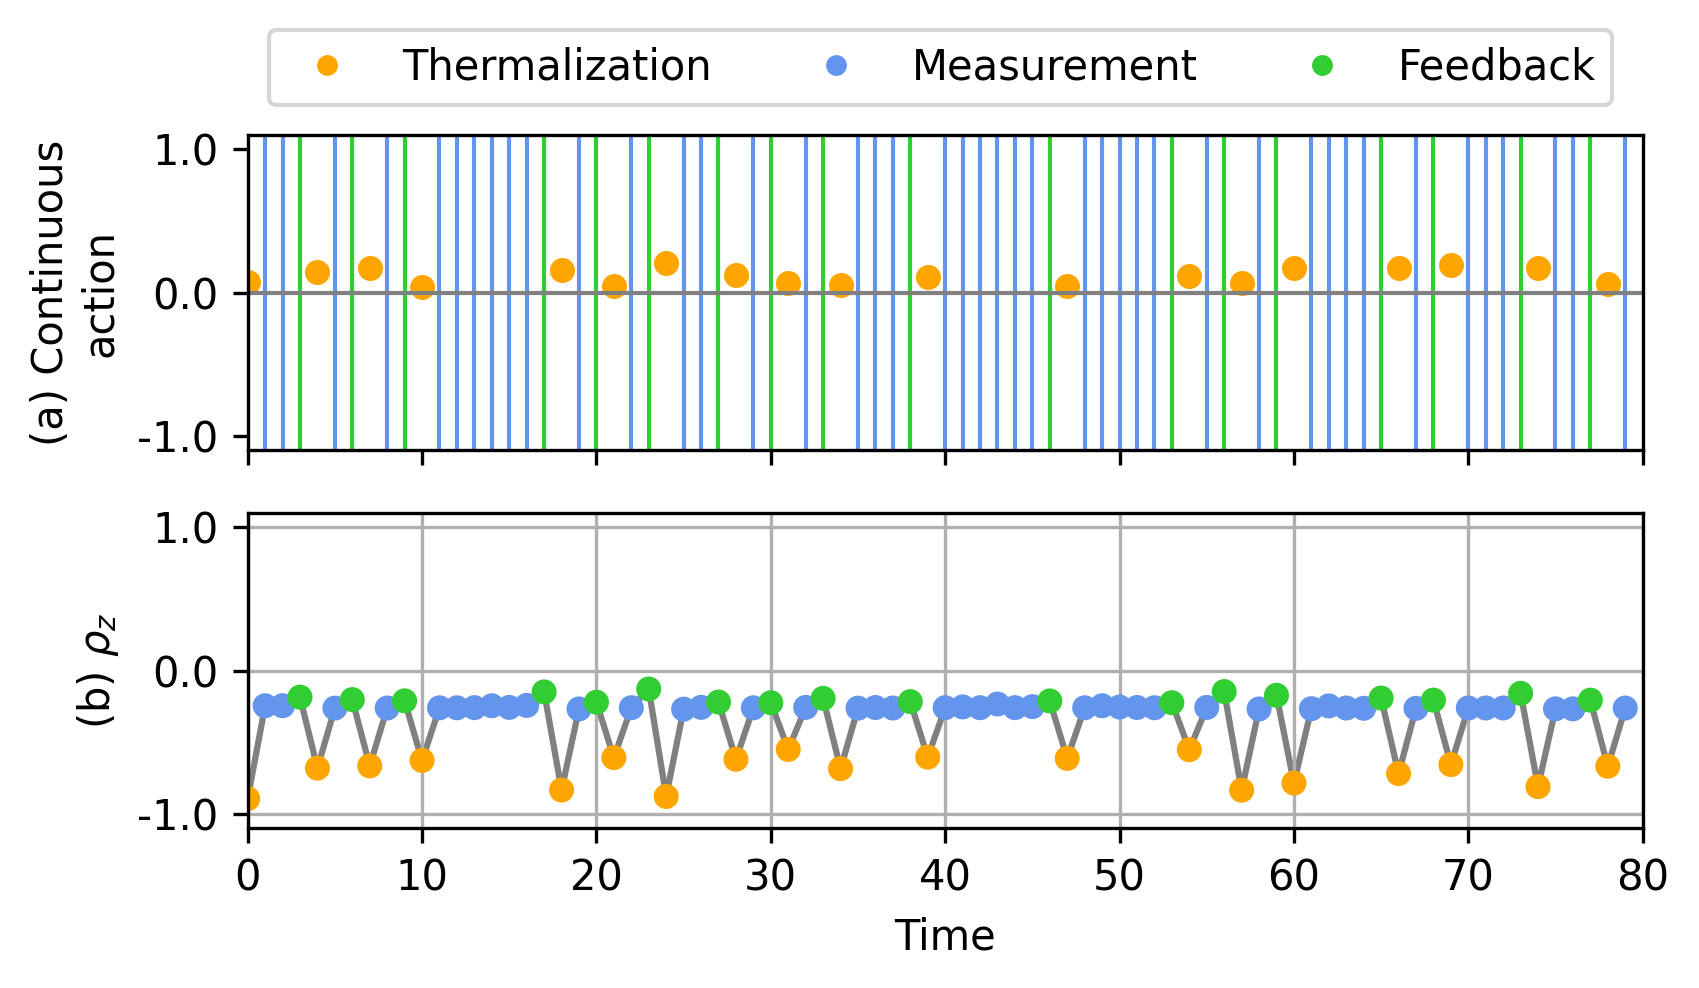

In [48]:
start = 0
n_steps = 80 #number of data points
finish = start + n_steps
TIME_STEP = loaded_train.env.dt 
start_time = start*TIME_STEP
end_time = (start + n_steps)*TIME_STEP

time_list = np.arange(start_time, end_time, TIME_STEP)

fig = plt.figure(figsize=(6,3))
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

# Generate data for first scatter plot
CONT_ACTIONS = info["continuous_actions"][start:finish]
DISC_ACTIONS = info["discrete_actions"][start:finish]

# Get thermalization times
times, gaps = extra.generate_action_times(
    time_list = time_list,
    dact_list = DISC_ACTIONS,
    uact_list = CONT_ACTIONS,
    target_dact = 0)

# Generate list for measurement times for first plot
meas_times, _ = extra.generate_action_times(
    time_list = time_list,
    dact_list = DISC_ACTIONS,
    uact_list = CONT_ACTIONS,
    target_dact = 1)

# Generate list for measurement times for first plot
rot_times, _ = extra.generate_action_times(
    time_list = time_list,
    dact_list = DISC_ACTIONS,
    uact_list = CONT_ACTIONS,
    target_dact = 2)

# the first subplot
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax0.scatter(times, gaps, 
            c = "orange", 
            s = 25, zorder=2 )
# Add vertical lines for measurement times
for time in meas_times:
    ax0.axvline(time, c = "cornflowerblue", linewidth = 1.)
for time in rot_times:
    ax0.axvline(time, c = "limegreen", linewidth = 1.)
ax0.axhline(0, c = "gray", linewidth = 1.)
ax0.set_ylim( [-1.1,1.1] )
ax0.set_ylabel("(a) Continuous\naction")
#ax0.set_xlim( left = start_time, right = end_time )
# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.grid()
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.plot( time_list, info["rhofz"][start:finish], "grey", zorder=1)
ax1.scatter(time_list, info["rhofz"][start:finish], 
            c = colors[start:finish], 
            s = 25, zorder=2 )
ax1.set_xlim( left = start_time, right = end_time )
ax1.set_ylabel(r"(b) $\rho_z$")
ax1.set_ylim( [-1.1,1.1] )
ax1.set_xlabel("Time")

plt.setp(ax0.get_xticklabels(), visible=False)

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Thermalization',
                          markerfacecolor='orange', markersize=6),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Measurement',
                          markerfacecolor='cornflowerblue', markersize=6),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Feedback',
                          markerfacecolor='limegreen', markersize=6)]

ax0.legend(handles=legend_elements, loc='upper left', ncols = len(legend_elements), bbox_to_anchor = [0.0,1.4])
# remove vertical gap between subplots
#plt.subplots_adjust(hspace=.0)
plt.rcParams['figure.dpi'] = 300
plt.show()